### Predicting Image Rotation
- Dataset selection &#x2705;
- Data Loaders &#x274C;
- Selecting Architecture &#x274C;
- Selecting Optimizer and Loss Function &#x274C;
- Training &#x274C;
- Inference &#x274C;
- Finetuning &#x274C;


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np 

# Custom dataset class to load original and rotated images
class RotationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.all_imgs_paths = []
        dir_list = [os.path.join(self.root_dir, directory) for directory in os.listdir(self.root_dir)]
        for dir_name in dir_list:
            self.all_imgs_paths.extend([os.path.join(dir_name, img_name) for img_name in os.listdir(dir_name)])
        

    def __len__(self):
        return len(self.all_imgs_paths)

    def __getitem__(self, idx):
        img_path = self.all_imgs_paths[idx]
        image = Image.open(img_path).convert("RGB")
        original_image = self.transform(image)

        # Rotate the image to generate additional samples
        rotated_images = [
            self.rotate_image(image, angle) for angle in [90, 180, 270]
        ]
        # Label each rotated image
        labels = torch.tensor([0, 1, 2, 3])
        
        # Concatenate original and rotated images
        images = torch.stack([original_image] + rotated_images)
        
        return images, labels
    
    
    def rotate_image(self, image, angle):
        image_np = np.array(image)
        rotated_image_np = np.rot90(image_np, k=int(angle // 90))
        rotated_image = Image.fromarray(rotated_image_np)
        return self.transform(rotated_image)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset using custom dataset class
train_dataset = RotationDataset(root_dir='imagenette2/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = RotationDataset(root_dir='imagenette2/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)



ValueError: degrees should be a sequence of length 2.

In [ ]:
# Get the first batch from the DataLoader
images, labels = next(iter(train_loader))

In [ ]:
labels.shape

torch.Size([16, 4])

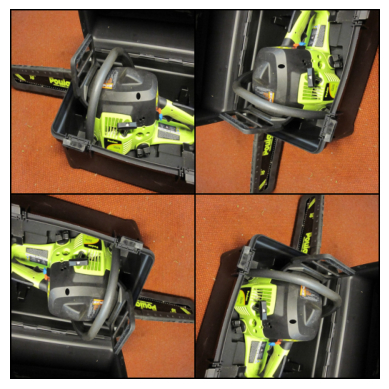

In [4]:
import matplotlib.pyplot as plt
import torchvision

# Function to display images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get the first batch from the DataLoader
images, labels = next(iter(train_loader))

# Visualize the batch of images
imshow(torchvision.utils.make_grid(images[0], nrow=2))  # nrow specifies the number of images per row in the grid


In [5]:
images.shape

torch.Size([64, 4, 3, 256, 256])

In [6]:
import torch

# Reshape the tensor
images_np = np.array(images)
images_np = images_np.reshape(-1, 3, 256, 256)

print(images_np.shape)


(256, 3, 256, 256)


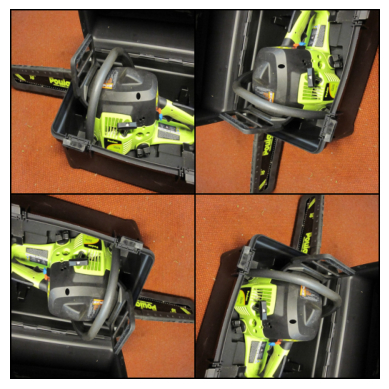

In [7]:
imshow(torchvision.utils.make_grid(torch.from_numpy(images_np[0:4]), nrow=2))  # nrow specifies the number of images per row in the grid


In [8]:
nn.Conv2d?

Object `nn.Conv2d` not found.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim


class RotationClassifier(nn.Module):
    def __init__(self, num_classes=1000):
        super(RotationClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = RotationClassifier(num_classes=4)  # Change num_classes as per your requirement

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.to(device)


RotationClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=4, bias=True)
  )
)

In [3]:
torch.cuda.is_available()

True

In [4]:
from tqdm.auto import tqdm

num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.reshape(-1, 3, 256, 256).to(device)
        labels = labels.flatten().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.reshape(-1, 3, 256, 256).to(device)
            labels = labels.flatten().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)
    
    val_loss /= len(val_dataset)
    val_accuracy = correct_preds.double() / total_preds
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

print("Training finished.")

  0%|          | 0/148 [00:00<?, ?it/s]

In [14]:
loss

tensor(0.9938, device='cuda:0', grad_fn=<NllLossBackward0>)